# Stacked Physics-Informed Neural Networks (SPINNs) in Neuromancer

This tutorial demonstrates the use of stacked (multi-fidelity) PINNs for solving challenging multiscale differential equations in the Neuromancer library.

<img src="../figs/multifidelity_pinn.png" width="1100">  
<!-- <img src="https://github.com/pnnl/neuromancer/tree/feature/multi_fidelity_pinns/examples/figs/multifidelity_pinn.png" width="600">   -->

### References

[1] [Howard, Amanda A., et al. (2023) Stacked networks improve physics-informed training: applications to neural networks and deep operator networks.](https://arxiv.org/abs/2311.06483)

[2] [Heinlein, Alexander, et al. (2023) Multifidelity domain decomposition-based physics-informed neural networks for time-dependent problems.](https://arxiv.org/abs/2401.07888)

## Install (Colab only)
Skip this step when running locally.

In [1]:
# !pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"
# !pip install pyDOE

## Imports

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from neuromancer.dataset import DictDataset
from neuromancer.modules import blocks
from neuromancer.system import Node
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer

from scipy.integrate import solve_ivp
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)


# Problem Setup

**The Pendulum Problem** is a fundamental example in classical mechanics, where the equations of motion describe the behavior of a simple pendulum under the influence of gravity and damping. The problem is given by the system of first-order ordinary differential equations:

$$
\frac{ds_1}{dt} = s_2,
$$
$$
\frac{ds_2}{dt} = -\frac{b}{m}s_2 - \frac{g}{L}\sin(s_1).
$$

Here, $s_1$ represents the angular displacement, and $s_2$ represents the angular velocity of the pendulum.

**Initial Conditions:**

The initial conditions are given by:
$$ s_1(0) = 0.5, $$
$$ s_2(0) = 0.5. $$

**Parameters:**

The parameters for this problem are:
- Mass of the pendulum $ m = 1 $ kg,
- Length of the pendulum $ L = 1 $ m,
- Damping coefficient $ b = 0.05 $ kg/s,
- Acceleration due to gravity $ g = 9.81 $ m/s²,
- Total simulation time $ T = 20 $ s.

### Pendulum Problem Loss Function Terms

#### Collocation Points Loss:

By approximating $ [s_1, s_2] \approx [s_1(t; \theta), s_2(t; \theta)] \coloneqq [s_{1\theta}, s_{2\theta}] $, we evaluate our Physics-Informed Neural Network (PINN) over a given number ($ N_{cp} $) of collocation points (CP) for each equation in the system and minimize the following residuals:

- For the angular displacement:
$$\ell_{cp1} = \frac{1}{N_{cp}} \sum_{i=1}^{N_{cp}} \left| \frac{ds_{1\theta}}{dt}(t_i) - s_{2\theta}(t_i) \right|^2$$

- For the angular velocity:
$$\ell_{cp2} = \frac{1}{N_{cp}} \sum_{i=1}^{N_{cp}} \left| \frac{ds_{2\theta}}{dt}(t_i) + \frac{b}{m} s_{2\theta}(t_i) + \frac{g}{L} \sin(s_{1\theta}(t_i)) \right|^2$$

#### Initial Conditions Loss:

We ensure the network respects the initial conditions with the following losses:

- For angular displacement:
$$\ell_{ic1} = \left| s_{1\theta}(0) - s_1(0) \right|^2$$

- For angular velocity:
$$\ell_{ic2} = \left| s_{2\theta}(0) - s_2(0) \right|^2$$

#### Total Loss:

The total loss is a sum of the residuals for each equation at collocation points combined with the residuals for initial conditions:

$$\ell_{\text{PINN}} = \omega_{cp1} \ell_{cp1} + \omega_{cp2} \ell_{cp2} + \omega_{ic1} \ell_{ic1} + \omega_{ic2} \ell_{ic2}$$

where $ \omega_{cp1}, \omega_{cp2}, \omega_{ic1}, \omega_{ic2} $ are scaling factors.


In [30]:
# Parameters
m = 1.0    # Mass (kg)
L = 1.0    # Length (m)
b = 0.05   # Damping coefficient (kg/s)
g = 9.81   # Acceleration due to gravity (m/s^2)
T = 20.0   # Total simulation time (s)

# Initial conditions
s1_0 = 0.5
s2_0 = 0.5

# Number of collocation points
N_cp = 500

# Time discretization
t = torch.linspace(0, T, N_cp).to(device)

# Initial conditions
ic_t = t[0].unsqueeze(0).unsqueeze(0)
ic_s1 = torch.tensor([s1_0]).unsqueeze(0).to(device)
ic_s2 = torch.tensor([s2_0]).unsqueeze(0).to(device)

# Collocation points
t_train_cp = t[1:].unsqueeze(1)

# Combine initial condition and collocation points for training
t_train = torch.cat((ic_t, t_train_cp)).float().to(device)
s_train = torch.cat((torch.tensor([[s1_0, s2_0]]).to(device), torch.zeros((t_train_cp.shape[0], 2)).to(device)))

t_train.requires_grad_(True)

# Create dataset
train_data = DictDataset({'t': t_train}, name='train')

# # Swish activation
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Neural net to solve the ODE problem
# Variables in: t; variables out: s (s1, s2)
net_sf = blocks.MLP(insize=1, outsize=2, hsizes=[200]*3, nonlin=Swish).to(device) # single-fideltiy (ref)
net_mf = blocks.MultiFidelityMLP(insize=1, outsize=2, n_stacked_mf_layers= 4, h_sf_size=[100]*3, nonlin=Swish,
                                 h_nonlinear_sizes=[50]*5, h_linear_sizes=[20,20],
                                 freeze_epochs=[10000, 20000, 30000, 40000], verbose=True)  # multi-fidelity

# Symbolic wrapper of the neural net
# Inputs: t
# outputs: s (s1, s2)
ode_net_sf = Node(net_sf, ['t'], ['s'], name='net_sf')
ode_net_mf = Node(net_mf, ['t'], ['s'], name='net_mf')

# Symbolic Neuromancer variables
s = variable('s')
s1 = s[:, [0]]  # Angular displacement
s2 = s[:, [1]]  # Angular velocity
t = variable('t')  # Time

# Define the ODE system
ds1_dt = s2
ds2_dt = -(b/m) * s2 - (g/L) * torch.sin(s1)

# Define the PINN form
f_pinn1 = s1.grad(t) - ds1_dt
f_pinn2 = s2.grad(t) - ds2_dt
f_pinn1_grad = f_pinn1.grad(t)
f_pinn2_grad = f_pinn2.grad(t)

# Scaling factors for better convergence
scaling_ic_sf = 1.0
scaling_cp_sf = 1.0
scaling_ic_mf = 1.0
scaling_cp_mf = 10.0

# ODE collocation points loss (MSE)
l_cp1_sf = scaling_cp_sf * (f_pinn1 == torch.tensor(0.).to(device))^2
l_cp2_sf = scaling_cp_sf * (f_pinn2 == torch.tensor(0.).to(device))^2

l_cp1_mf = scaling_cp_mf * (f_pinn1 == torch.tensor(0.).to(device))^2
l_cp2_mf = scaling_cp_mf * (f_pinn2 == torch.tensor(0.).to(device))^2

# Initial condition loss (MSE)
l_ic1_sf = scaling_ic_sf * (s1[0] - ic_s1 == torch.tensor(0.).to(device))^2
l_ic2_sf = scaling_ic_sf * (s2[0] - ic_s2 == torch.tensor(0.).to(device))^2
l_ic1_mf = scaling_ic_mf * (s1[0] - ic_s1 == torch.tensor(0.).to(device))^2
l_ic2_mf = scaling_ic_mf * (s2[0] - ic_s2 == torch.tensor(0.).to(device))^2

# Combined loss
loss_sf = PenaltyLoss(objectives=[l_cp1_sf, l_cp2_sf, l_ic1_sf, l_ic2_sf], constraints=[])
loss_mf = PenaltyLoss(objectives=[l_cp1_mf, l_cp2_mf, l_ic1_mf, l_ic2_mf], constraints=[])

# Construct the PINN optimization problem
problem_sf = Problem(nodes=[ode_net_sf], loss=loss_sf, grad_inference=True)
problem_mf = Problem(nodes=[ode_net_mf], loss=loss_mf, grad_inference=True)

# Optimizer
optimizer_sf = torch.optim.AdamW(problem_sf.parameters(), lr=1e-3)
optimizer_mf = torch.optim.AdamW(problem_mf.parameters(), lr=1e-3)


In [31]:
# Print parameter counts
print(f" Total number of parameters in single-fidelity net= {sum(p.numel() for p in net_sf.parameters())}")
print(f" Total number of parameters in multi-fidelity net= {sum(p.numel() for p in net_mf.parameters())}")


 Total number of parameters in single-fidelity net= 81202
 Total number of parameters in multi-fidelity net= 64702


In [32]:
# Print single-fidelity net
print(net_sf)

MLP(
  (nonlin): ModuleList(
    (0-2): 3 x Swish()
    (3): Identity()
  )
  (linear): ModuleList(
    (0): Linear(
      (linear): Linear(in_features=1, out_features=200, bias=True)
    )
    (1-2): 2 x Linear(
      (linear): Linear(in_features=200, out_features=200, bias=True)
    )
    (3): Linear(
      (linear): Linear(in_features=200, out_features=2, bias=True)
    )
  )
)


In [33]:
# Print multi-fidelity net
print(net_mf)

MultiFidelityMLP(
  (alpha): ParameterList(
      (0): Parameter containing: [torch.float32 of size ]
      (1): Parameter containing: [torch.float32 of size ]
      (2): Parameter containing: [torch.float32 of size ]
      (3): Parameter containing: [torch.float32 of size ]
  )
  (first_layer): MLP(
    (nonlin): ModuleList(
      (0-2): 3 x Swish()
      (3): Identity()
    )
    (linear): ModuleList(
      (0): Linear(
        (linear): Linear(in_features=1, out_features=100, bias=True)
      )
      (1-2): 2 x Linear(
        (linear): Linear(in_features=100, out_features=100, bias=True)
      )
      (3): Linear(
        (linear): Linear(in_features=100, out_features=2, bias=True)
      )
    )
  )
  (layers): ModuleList(
    (0-3): 4 x ModuleDict(
      (linear): MLP(
        (nonlin): ModuleList(
          (0-2): 3 x Identity()
        )
        (linear): ModuleList(
          (0): Linear(
            (linear): Linear(in_features=2, out_features=20, bias=True)
          )
      

### Train single-fidelity net

In [34]:
# Number of epochs
epochs_sf = 50000

# Neuromancer trainer
trainer_sf = Trainer(
    problem_sf.to(device),
    torch.utils.data.DataLoader(train_data, batch_size=t_train.shape[0],
                                collate_fn=train_data.collate_fn, shuffle=False),
    optimizer=optimizer_sf,
    epochs=epochs_sf,
    epoch_verbose=5000,
    train_metric='train_loss',
    dev_metric='train_loss',
    eval_metric="train_loss",
    warmup=epochs_sf,
    device=device
)

# Train PINN
best_model_sf = trainer_sf.train()

# Load best trained model
problem_sf.load_state_dict(best_model_sf)


epoch: 0  train_loss: 6.502745151519775
epoch: 5000  train_loss: 0.00559229264035821
epoch: 10000  train_loss: 0.005571959540247917
epoch: 15000  train_loss: 0.003700061934068799
epoch: 20000  train_loss: 0.0034458551090210676
epoch: 25000  train_loss: 0.00325898383744061
epoch: 30000  train_loss: 0.004007370211184025
epoch: 35000  train_loss: 0.002578500658273697
epoch: 40000  train_loss: 0.002647434826940298
epoch: 45000  train_loss: 0.00306437979452312


<All keys matched successfully>

### Train multi-fidelity net

In [35]:
# Number of epochs
epochs_mf = 50000

# Neuromancer trainer 
trainer_mf = Trainer(
    problem_mf.to(device),
    torch.utils.data.DataLoader(train_data, batch_size=t_train.shape[0],
                                collate_fn=train_data.collate_fn, shuffle=False),
    optimizer=optimizer_mf,
    epochs=epochs_mf,
    epoch_verbose=5000,
    train_metric='train_loss',
    dev_metric='train_loss',
    eval_metric="train_loss",
    warmup=epochs_mf,
    device=device,
    multi_fidelity=True
)

# Train PINN
best_model_mf = trainer_mf.train()

# Load best trained model
problem_mf.load_state_dict(best_model_mf)


epoch: 0  train_loss: 322.3371887207031
epoch: 5000  train_loss: 0.045722536742687225
Single-fidelity (0th layer) parameters have been frozen
Now training stacked block 1
epoch: 10000  train_loss: 0.039826929569244385
epoch: 15000  train_loss: 0.039754144847393036
Multi-fidelity (layer 1) parameters have been frozen
Weights copied for layer 2
Now training stacked block 2
epoch: 20000  train_loss: 0.05238194018602371
epoch: 25000  train_loss: 0.023618271574378014
Multi-fidelity (layer 2) parameters have been frozen
Weights copied for layer 3
Now training stacked block 3
epoch: 30000  train_loss: 0.02015089802443981
epoch: 35000  train_loss: 0.016711708158254623
Multi-fidelity (layer 3) parameters have been frozen
Weights copied for layer 4
Now training stacked block 4
epoch: 40000  train_loss: 0.01575048826634884
epoch: 45000  train_loss: 0.012667061761021614


<All keys matched successfully>

### Compare results

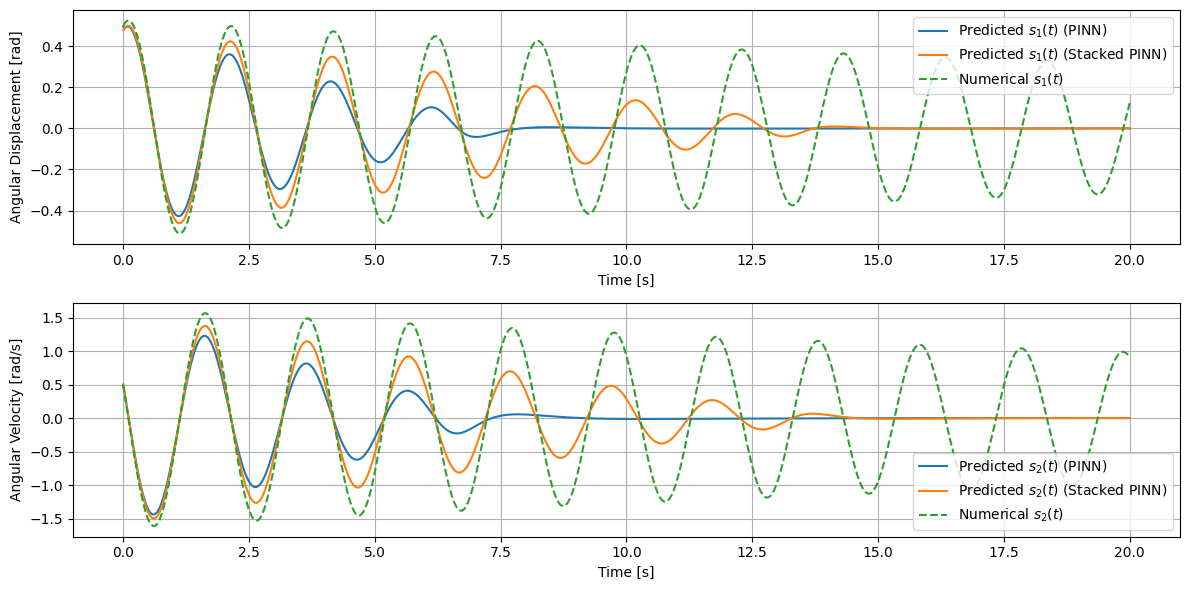

In [36]:
# Visualize results

# Single-fidelity predictions
s_pred_sf = ode_net_sf(train_data.datadict)['s'].detach().cpu().numpy()
s1_pred_sf = s_pred_sf[:, 0]
s2_pred_sf = s_pred_sf[:, 1]
t_train = train_data.datadict['t'].detach().cpu().numpy()

# Multi-fidelity predictions
s_pred_mf = ode_net_mf(train_data.datadict)['s'].detach().cpu().numpy()
s1_pred_mf = s_pred_mf[:, 0]
s2_pred_mf = s_pred_mf[:, 1]

# Compare with numerical solution of ODE solver
# Define the ODE system for numerical solution
def pendulum_ode(t, y):
    s1, s2 = y
    ds1_dt = s2
    ds2_dt = -b/m * s2 - g/L * np.sin(s1)
    return [ds1_dt, ds2_dt]

# Initial conditions for numerical solution
y0 = [s1_0, s2_0]

# Time points for numerical solution
t_span = (0, T)
t_eval = np.linspace(0, T, N_cp)

# Solve the ODE numerically
sol = solve_ivp(pendulum_ode, t_span, y0, t_eval=t_eval)

# Plot the results
plt.figure(figsize=(12, 6))

# Angular Displacement
plt.subplot(2, 1, 1)
plt.plot(t_train, s1_pred_sf, label='Predicted $s_1(t)$ (PINN)')
plt.plot(t_train, s1_pred_mf, label='Predicted $s_1(t)$ (Stacked PINN)')
plt.plot(sol.t, sol.y[0], label='Numerical $s_1(t)$', linestyle='dashed')
plt.xlabel('Time [s]')
plt.ylabel('Angular Displacement [rad]')
plt.legend()
plt.grid(True)

# Angular Velocity
plt.subplot(2, 1, 2)
plt.plot(t_train, s2_pred_sf, label='Predicted $s_2(t)$ (PINN)')
plt.plot(t_train, s2_pred_mf, label='Predicted $s_2(t)$ (Stacked PINN)')
plt.plot(sol.t, sol.y[1], label='Numerical $s_2(t)$', linestyle='dashed')
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity [rad/s]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [37]:
# Verify that final parameter alpha is small (see Eq. 11 of Howard, Amanda A. et al. 2023).
for idx,alpha in enumerate(net_mf.alpha):
    print(f"alpha_{idx} = {alpha}")


alpha_0 = Parameter containing:
tensor(0.0991, requires_grad=True)
alpha_1 = Parameter containing:
tensor(0.0947, requires_grad=True)
alpha_2 = Parameter containing:
tensor(0.0962, requires_grad=True)
alpha_3 = Parameter containing:
tensor(0.0942, requires_grad=True)
